In [1]:
#| default_exp training

In [2]:
#| hide
from nbdev.showdoc import *

# training
> This module will contain the TTSDataset and the collate function used in training

In [3]:
#| export 
from fastspeech.data import *
import torch
from fastspeech.visualize import show_mel, plot_loss
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_value_
from tqdm.auto import tqdm
from torch import tensor
from pathlib import Path

In [4]:
#| hide
from fastspeech.modules import FastSpeech, FFTConfig, DPConfig
from fastspeech.preprocess import ZScoreNormalization, MinMaxNormalization
from fastspeech.data import *
from torch.optim import Adam
from functools import partial
import torch.nn.functional as F

In [5]:
#| export
def mae_loss(pred: tensor, target: tensor): 
    return torch.abs(target - pred).mean()

In [6]:
mae_loss(tensor([1.,2,3]), tensor([2.,6.5,4]))

tensor(2.1667)

In [7]:
#| export
class TransformerScheduler:
    def __init__(self, optimizer, lr_mul:float, d_model:int, n_warmup_steps:int):
        self._optimizer = optimizer
        self.lr_mul, self.d_model = lr_mul, d_model
        self.n_warmup_steps, self.n_steps = n_warmup_steps, 0

    def step(self):
        self._update_learning_rate()

    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))
    
    def _update_learning_rate(self):
        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [20]:
#| export
class FastspeechLearner:
    def __init__(self, dl: DataLoader, norm, Model, Optimizer, Scheduler, 
                 config: dict, loss_fn_a, loss_fn_b, accum_grad: int=1, 
                 grad_clip: float=1., fp_16: bool=False, log_interval: int=10, 
                 checkpoint_dir="../checkpoints", device=None):
        
        self.dl, self.norm, self.config = dl, norm, config
        self.checkpoint_dir = checkpoint_dir
        self.model = Model(**config["model"]).to(device)
        self.optim = Optimizer(self.model.parameters(), **config["optim"])
        self.scheduler = Scheduler(self.optim, **config["scheduler"])
        
        self.loss_fn_a, self.loss_fn_b = loss_fn_a, loss_fn_b
        
        self.accum_grad, self.grad_clip = accum_grad, grad_clip
        self.fp_16, self.log_interval = fp_16, log_interval
        self.device, self.scaler = device, GradScaler(enabled=self.fp_16)
        
        self.save_num = 0
        self.mel_history = []
        self.loss_history = {"a": [], "b": []}
        
    def one_step(self, inp: tuple):
        phones, durations, mels = map(lambda x: x.to(self.device), inp)
        log_durations = (durations + 1e-20).log()
        d_slice = (slice(None), slice(None, -1))
        self.optim.zero_grad()
        
        with autocast(enabled=self.fp_16):
            pred_mels, pred_log_durations = self.model(phones, durations)
            loss_a = self.loss_fn_a(pred_mels, mels)
            loss_b =  self.loss_fn_b(pred_log_durations[d_slice], log_durations[d_slice])
        
        self.scaler.scale(loss_a).backward()
        self.scaler.scale(loss_b).backward()
        
        clip_grad_value_(self.model.parameters(), self.grad_clip)
        
        return loss_a.detach(), loss_b.detach()
    
    def fit(self, steps: int):
        curr_steps = 0
        
        val_phone, val_duration, val_mel = next(iter(self.dl))
        show_mel(self.norm.denormalize(val_mel)[0], "validation")
              
        progress_bar = tqdm(total=steps, desc="Training", unit="step")
        while curr_steps < steps:
            for batch in self.dl:
                if curr_steps > steps: break
                    
                loss_a, loss_b = self.one_step(batch)
                
                if curr_steps % self.accum_grad == 0 or (curr_steps+1) == len(self.dl):
                    self.scaler.step(self.optim)
                    self.scaler.update()
                    self.scheduler.step()
                
                curr_steps += 1
                loss_a, loss_b = loss_a.cpu(), loss_b.cpu()
                self._update_bar_and_history(progress_bar, loss_a, loss_b)
                
                if curr_steps % self.log_interval == 0 or curr_steps == steps:
                    with torch.no_grad(): 
                        pred_mel, _ = self.model(val_phone.to(self.device), 
                                                 val_duration.to(self.device))
                        pred_mel = self.norm.denormalize(pred_mel).cpu()
                    
                    save_path = Path(self.checkpoint_dir)/f"save_{self.save_num}"
                    Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)
                    
                    self.save_model(save_path)
        
                    self.mel_history.append(pred_mel)
            
                    loss_slice = slice(min(0, curr_steps-self.log_interval), curr_steps)
                    avg_loss = tensor(self.loss_history["a"][loss_slice]).mean()
                    
                    title = f"step: {curr_steps}, loss: {avg_loss:.4f}"
                    show_mel(pred_mel[0], title)
                    
        progress_bar.close()
        
    def _update_bar_and_history(self, progress_bar, loss_a, loss_b):
        self.loss_history['a'].append(loss_a)
        self.loss_history['b'].append(loss_b)
        
        progress_bar.update(1)
        loss_output = {"m_loss": f"{loss_a:.4f}", 
                       "d_loss": f"{loss_b:.2f}"}
        progress_bar.set_postfix(loss_output, refresh=True)
        
    def save_model(self, file_path):
        torch.save({
            "state_dict": {
                'model': self.model.state_dict(),
                'optim': self.optim.state_dict(),
            },
            "config": self.config,
            "norm": self.norm,
        }, file_path)
    
    def load_model_state_dict(self, sd: dict):
        self.model.load_state_dict(sd["model"])
        self.optim.load_state_dict(sd["optim"])

In [21]:
#| hide
path = "../sample_data"
path_vocab = "../sample_data/cmudict-0.7b.symbols.txt"

ds = TTSDataset(path, path_vocab, ZScoreNormalization, preload=True, 
                stats={'max_val': 100., 'min_val': .01, "mean": 0.01,
                       "std": 0.20, "top_db": 35})

dl = DataLoader(ds, 2, collate_fn=partial(collate_fn, pad_num=ds.vocab.pad_num, 
                                          norm=ds.norm))

In [22]:
ni = 18
config = {
    "model": {
        "ne": len(ds.vocab.vocab), "ni": ni, "no": 80, 
        "ec": FFTConfig(ni=ni, nh=2, fs=32, ks=[3,3], p=[0.1,0.1]), "enb": 2, 
        "dc": FFTConfig(ni=ni, nh=2, fs=32, ks=[3,3], p=[0.1,0.1]), "dnb": 2, 
        "dpc": DPConfig(ni=ni, fs=32, ks=[3,3], p=[0.1,0.1])
    },
    "optim": {"lr":  1e-4, "betas": (0.9, 0.98), "eps": 1e-10, "weight_decay": 0},
    "scheduler": {"lr_mul": 1., "d_model": ni, "n_warmup_steps": 4000},
}

learner = FastspeechLearner(dl, ds.norm, FastSpeech, Adam, TransformerScheduler, 
                            config, mae_loss, F.mse_loss, log_interval=5)

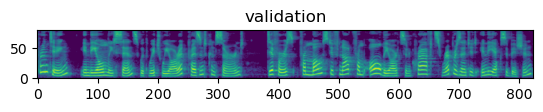

Training:   0%|          | 0/10 [00:00<?, ?step/s]

[tensor(1.9596), tensor(1.9559), tensor(1.9580), tensor(1.9487), tensor(1.9578)]


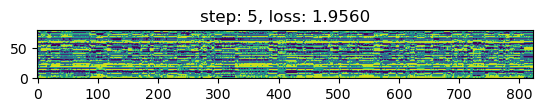

[tensor(1.9596), tensor(1.9559), tensor(1.9580), tensor(1.9487), tensor(1.9578), tensor(1.9492), tensor(1.9565), tensor(1.9544), tensor(1.9536), tensor(1.9552)]


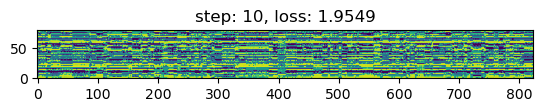

In [23]:
learner.fit(10)

In [ ]:
file_path = "../checkpoints/save_2.pt"
learner.save_model(file_path)
!ls ../checkpoints/

In [ ]:
#| export
def count_parameters(model: torch.nn.Module):
    return  sum([p.numel() for p in model.parameters() if p.requires_grad])

In [ ]:
count_parameters(learner.model)

In [ ]:
#| export
def load_checkpoint(file_path: str):
    checkpoint = torch.load(file_path)
    return checkpoint["state_dict"], checkpoint["config"], checkpoint["norm"]

In [ ]:
state_dict, config, norm = load_checkpoint(file_path)
learner = FastspeechLearner(dl, norm, FastSpeech, Adam, TransformerScheduler,
                            config, mae_loss, F.mse_loss, log_interval=5)
learner.load_model_state_dict(state_dict)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()